# TC3006B
## Deep Learning
# Script para elegir 300 imágenes al azar del bucket de s3 y obtener su meta-data

### Preparations for the script
You need to install the aws cli in order for the script to work: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

Once installed, run the command 

*aws configure*

It will ask you for some keys that are hidden for security purposes. For the region put us-east-1 and for output leave it as default "json".

And for the libraries just run 

*pip install -r requirements.txt*

If everything is configured correctly you may run now the script.

## Creación del csv

### Imports

In [115]:
import boto3
import csv
import random
from io import BytesIO
from PIL import Image, ImageStat
from concurrent.futures import ThreadPoolExecutor, as_completed

### Variables globales

In [116]:
# Configuración
BUCKET_NAME = 'caetec-vacas'  # Reemplaza con tu nombre de bucket
OUTPUT_CSV = 's3_image_metadata_advanced_with_histograms.csv'
MAX_IMAGES = 3000  # Número máximo de imágenes a procesar
MAX_WORKERS = 10  # Número de hilos para procesamiento paralelo

### Creamos una lista con todos los objetos de la bucket

In [117]:
def list_all_objects(s3_client, bucket):
    paginator = s3_client.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket)
    all_objects = []
    for page in page_iterator:
        contents = page.get('Contents', [])
        all_objects.extend(contents)
    return all_objects

### Procesamos cada imagen obteniendo la meta-data de la misma, witdh, height, luminosity, contrast e histogramas rgb

In [118]:
def process_object(s3_client, bucket, obj):
    key = obj['Key']
    last_modified = obj['LastModified']
    size = obj['Size']
    etag = obj['ETag']
    storage_class = obj.get('StorageClass', 'STANDARD')
    
    # Inicializar variables para características avanzadas
    width, height = None, None
    luminosity, contrast = None, None
    histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    try:
        # Descargar la imagen en memoria
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Asegurar que la imagen esté en RGB
        
        # Obtener dimensiones de la imagen
        width, height = image.size
        
        # Convertir la imagen a escala de grises para calcular luminosidad y contraste
        grayscale_image = image.convert('L')
        stat = ImageStat.Stat(grayscale_image)
        
        # Calcular la luminosidad (media de los valores de píxel)
        luminosity = stat.mean[0]
        
        # Calcular el contraste (desviación estándar de los valores de píxel)
        contrast = stat.stddev[0]
        
        # Calcular histogramas para cada canal
        histogram = image.histogram()
        # Histograma tiene 256 valores por canal (R, G, B)
        histogram_red = histogram[0:256]
        histogram_green = histogram[256:512]
        histogram_blue = histogram[512:768]
        
    except Exception as e:
        print(f"Error procesando {key}: {e}")
        # Asignar valores predeterminados o continuar según sea necesario
        width, height = None, None
        luminosity, contrast = None, None
        histogram_red, histogram_green, histogram_blue = [None]*256, [None]*256, [None]*256
    
    # Preparar los histogramas como cadenas de texto
    histogram_red_str = ';'.join(map(str, histogram_red)) if histogram_red else ''
    histogram_green_str = ';'.join(map(str, histogram_green)) if histogram_green else ''
    histogram_blue_str = ';'.join(map(str, histogram_blue)) if histogram_blue else ''
    
    Url = f"https://{bucket}.s3.amazonaws.com/{key}"
    
    return [
        key, Url, last_modified, size, etag, 
        storage_class,
        width, height, luminosity, contrast,
        histogram_red_str, histogram_green_str, histogram_blue_str
    ]

### Creamos la funcion main y escribimos en el meta-data

In [119]:
def main():
    # Inicializar el cliente de S3
    s3 = boto3.client('s3')
    
    # Listar todos los objetos en el bucket
    print("Listando objetos en el bucket...")
    all_objects = list_all_objects(s3, BUCKET_NAME)
    total_objects = len(all_objects)
    print(f"Total de objetos en el bucket: {total_objects}")
    
    if total_objects == 0:
        print("No se encontraron objetos en el bucket.")
        return
    
    # Elegir 300 objetos al azar si hay suficientes, si no, toma todos
    sample_size = min(total_objects, MAX_IMAGES)
    sampled_objects = random.sample(all_objects, sample_size)
    print(f"Seleccionando {sample_size} objetos al azar para procesar...")
    
    # Definir los encabezados del CSV
    headers = [
        'Key', 'Url', 'LastModified', 'Size', 'ETag', 
        'StorageClass',
        'Width', 'Height', 'Luminosity', 'Contrast',
        'Histogram_Red', 'Histogram_Green', 'Histogram_Blue'
    ]
    
    # Procesar los objetos en paralelo para mejorar el rendimiento
    print("Procesando objetos y extrayendo metadata...")
    processed_data = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        # Enviar tareas al pool de hilos
        futures = {executor.submit(process_object, s3, BUCKET_NAME, obj): obj for obj in sampled_objects}
        for future in as_completed(futures):
            data = future.result()
            processed_data.append(data)
    
    # Escribir los datos en el CSV
    print(f"Escribiendo metadata en el archivo CSV: {OUTPUT_CSV}")
    with open(OUTPUT_CSV, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Escribir encabezados
        writer.writerows(processed_data)  # Escribir filas de datos
    
    print(f"CSV creado con {sample_size} registros de metadata avanzados seleccionados al azar.")


### Corremos el programa

In [120]:
if __name__ == "__main__":
    main()

Listando objetos en el bucket...
Total de objetos en el bucket: 2189
Seleccionando 2189 objetos al azar para procesar...
Procesando objetos y extrayendo metadata...
Error procesando train/: cannot identify image file <_io.BytesIO object at 0x75c569b28d10>
Escribiendo metadata en el archivo CSV: s3_image_metadata_advanced_with_histograms.csv
CSV creado con 2189 registros de metadata avanzados seleccionados al azar.


## Creamos gráficas para visualización de la información en el csv

### Imports

In [138]:
# Importar las bibliotecas necesarias
import pandas as pd
import seaborn as sns
from PIL import Image

# Configurar estilos para las gráficas
sns.set(style="whitegrid")
%matplotlib inline


### Pasamor el csv a pandas

In [139]:
# Cargar el CSV en un DataFrame de pandas
df = pd.read_csv('s3_image_metadata_advanced_with_histograms.csv')


### Limpiamos registro erroneo en csv

In [140]:
df = df[df['Key'] != 'train/']

### Visualizamos csv

In [141]:
df.dropna()

Key  \
0     validation/1/2024-05-16-20-50-03_jpg.rf.618b2a...   
1     train/4/2024-05-21-15-30-03_jpg.rf.c6fe1d4956e...   
2     validation/4/2024-05-18-21-55-03_jpg.rf.3bb865...   
3     validation/5/2024-05-19-00-00-09_jpg.rf.b4c319...   
4     validation/9/2024-05-17-10-00-03_jpg.rf.cc7db0...   
...                                                 ...   
2184  test/5/2024-05-03-17-00-04_jpg.rf.37ed94475d83...   
2185  train/5/2024-05-19-17-25-04_jpg.rf.58c04fc8488...   
2186  test/4/2024-04-28-14-20-03_jpg.rf.beefc3aa471f...   
2187  test/4/2024-05-02-23-45-03_jpg.rf.f0c140f8cf89...   
2188  test/3/2024-05-03-17-15-04_jpg.rf.98117e57f01b...   

                                                    Url  \
0     https://caetec-vacas.s3.amazonaws.com/validati...   
1     https://caetec-vacas.s3.amazonaws.com/train/4/...   
2     https://caetec-vacas.s3.amazonaws.com/validati...   
3     https://caetec-vacas.s3.amazonaws.com/validati...   
4     https://caetec-vacas.s3.amazonaws.com/validati...   
...                                                 ...   
2184  https://caetec-vacas.s3.amazonaws.com/test/5/2...   
2185  https://caetec-vacas.s3.amazonaws.com/train/5/...   
2186  https://caetec-vacas.s3.amazonaws.com/test/4/2...   
2187  https://caetec-vacas.s3.amazonaws.com/test/4/2...   
2188  https://caetec-vacas.s3.amazonaws.com/test/3/2...   

                   LastModified    Size                                ETag  \
0     2024-10-14 18:18:55+00:00   31857  "719183e9760f16d5df5c4a101854b923"   
1     2024-10-14 18:12:40+00:00  236987  "7adf0ec752257085bfa52c64702a4267"   
2     2024-10-14 18:17:16+00:00   26445  "a8b2d4a484d90a848a19ae3c63abe567"   
3     2024-10-14 18:16:34+00:00   31835  "78080265ca0e79999bcbba8e3a59cc1c"   
4     2024-10-14 18:15:10+00:00   51553  "40d3cb3d12b972550ea281f32949b4da"   
...                         ...     ...                                 ...   
2184  2024-10-14 18:23:12+00:00  254482  "4d1526e36cb58dedd5ee72a50ada7341"   
2185  2024-10-14 18:13:23+00:00  203141  "c92e26a5e539952ed24cdd546230d089"   
2186  2024-10-14 18:23:51+00:00  199409  "fe774a08a692c2b40cff35b94df61135"   
2187  2024-10-14 18:24:02+00:00  127063  "9c78e1d29941f7f5528290e716537027"   
2188  2024-10-14 18:25:39+00:00  276472  "bb0efe7fa32bbf0b508c509afe5f69c1"   

     StorageClass   Width  Height  Luminosity   Contrast  \
0        STANDARD   640.0   640.0   10.290024   9.651236   
1        STANDARD  1920.0  1080.0   98.459675  73.106673   
2        STANDARD   640.0   640.0   11.913821  19.942701   
3        STANDARD   640.0   640.0   12.757627  19.009063   
4        STANDARD   640.0   640.0  111.511567  70.462044   
...           ...     ...     ...         ...        ...   
2184     STANDARD  1920.0  1080.0  100.728648  62.673228   
2185     STANDARD  1920.0  1080.0  107.059144  73.861127   
2186     STANDARD  1920.0  1080.0  107.147954  69.801069   
2187     STANDARD  1920.0  1080.0   15.734259  20.643056   
2188     STANDARD  1920.0  1080.0  110.709284  61.088915   

                                          Histogram_Red  \
0     5292;14591;15087;20628;19700;18324;18466;18115...   
1     1;3;9;18;29;84;155;466;1581;4063;3708;3923;492...   
2     43893;66561;39271;32098;21962;16091;13995;1196...   
3     8085;32845;30139;30605;26333;22969;20840;18873...   
4     0;0;0;0;0;0;0;0;0;0;0;0;0;2;0;2;9;15;36;77;120...   
...                                                 ...   
2184  0;0;0;0;0;1;0;2;4;13;149;384;1092;1952;3229;66...   
2185  0;0;0;0;1;0;1;0;5;16;177;664;1622;4212;5321;81...   
2186  11;4;6;11;7;8;27;32;67;105;273;630;1106;2126;2...   
2187  49068;146326;179342;126703;86723;72924;63661;5...   
2188  0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;9;101;48...   

                                        Histogram_Green  \
0     20298;33057;37986;35958;31682;27736;24156;2078...   
1     10;6;11;20;24;97;225;725;1490;3313;9633;17958;...   
2     67821;89760;47713;29853;20188;14795;10984;8418...   
3     32290;55741;5

### Convertimos la cadena de histogramas en strings a int

In [142]:

# Definir una función mejorada para convertir la cadena de histograma en una lista de enteros
def histogram_str_to_list(hist_str):
    if pd.isna(hist_str) or hist_str.strip().lower() == 'none' or hist_str.strip() == '':
        return [0] * 256
    try:
        # Intentar convertir cada elemento a entero
        return list(map(int, hist_str.split(';')))
    except ValueError:
        # Si hay un valor no convertible, retornar una lista de ceros
        return [0] * 256

# Aplicar la función a las columnas de histogramas
df['Histogram_Red'] = df['Histogram_Red'].apply(histogram_str_to_list)
df['Histogram_Green'] = df['Histogram_Green'].apply(histogram_str_to_list)
df['Histogram_Blue'] = df['Histogram_Blue'].apply(histogram_str_to_list)

# Verificar la conversión
df[['Histogram_Red', 'Histogram_Green', 'Histogram_Blue']].head()


Histogram_Red  \
0  [5292, 14591, 15087, 20628, 19700, 18324, 1846...   
1  [1, 3, 9, 18, 29, 84, 155, 466, 1581, 4063, 37...   
2  [43893, 66561, 39271, 32098, 21962, 16091, 139...   
3  [8085, 32845, 30139, 30605, 26333, 22969, 2084...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...   

                                     Histogram_Green  \
0  [20298, 33057, 37986, 35958, 31682, 27736, 241...   
1  [10, 6, 11, 20, 24, 97, 225, 725, 1490, 3313, ...   
2  [67821, 89760, 47713, 29853, 20188, 14795, 109...   
3  [32290, 55741, 50258, 41206, 32603, 25216, 200...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   

                                      Histogram_Blue  
0  [106886, 56001, 46801, 40964, 35378, 29267, 23...  
1  [8604, 6381, 11043, 17425, 26505, 31113, 38426...  
2  [138015, 92684, 37696, 24047, 16978, 12452, 93...  
3  [90655, 71497, 53634, 40524, 29669, 22101, 159...  
4  [1, 1, 0, 1, 1, 3, 5, 3, 0, 4, 13, 15, 20, 51,...

### Seleccionamos una imagen al azar y ploteamos los histogramas con la intensidad de rgb

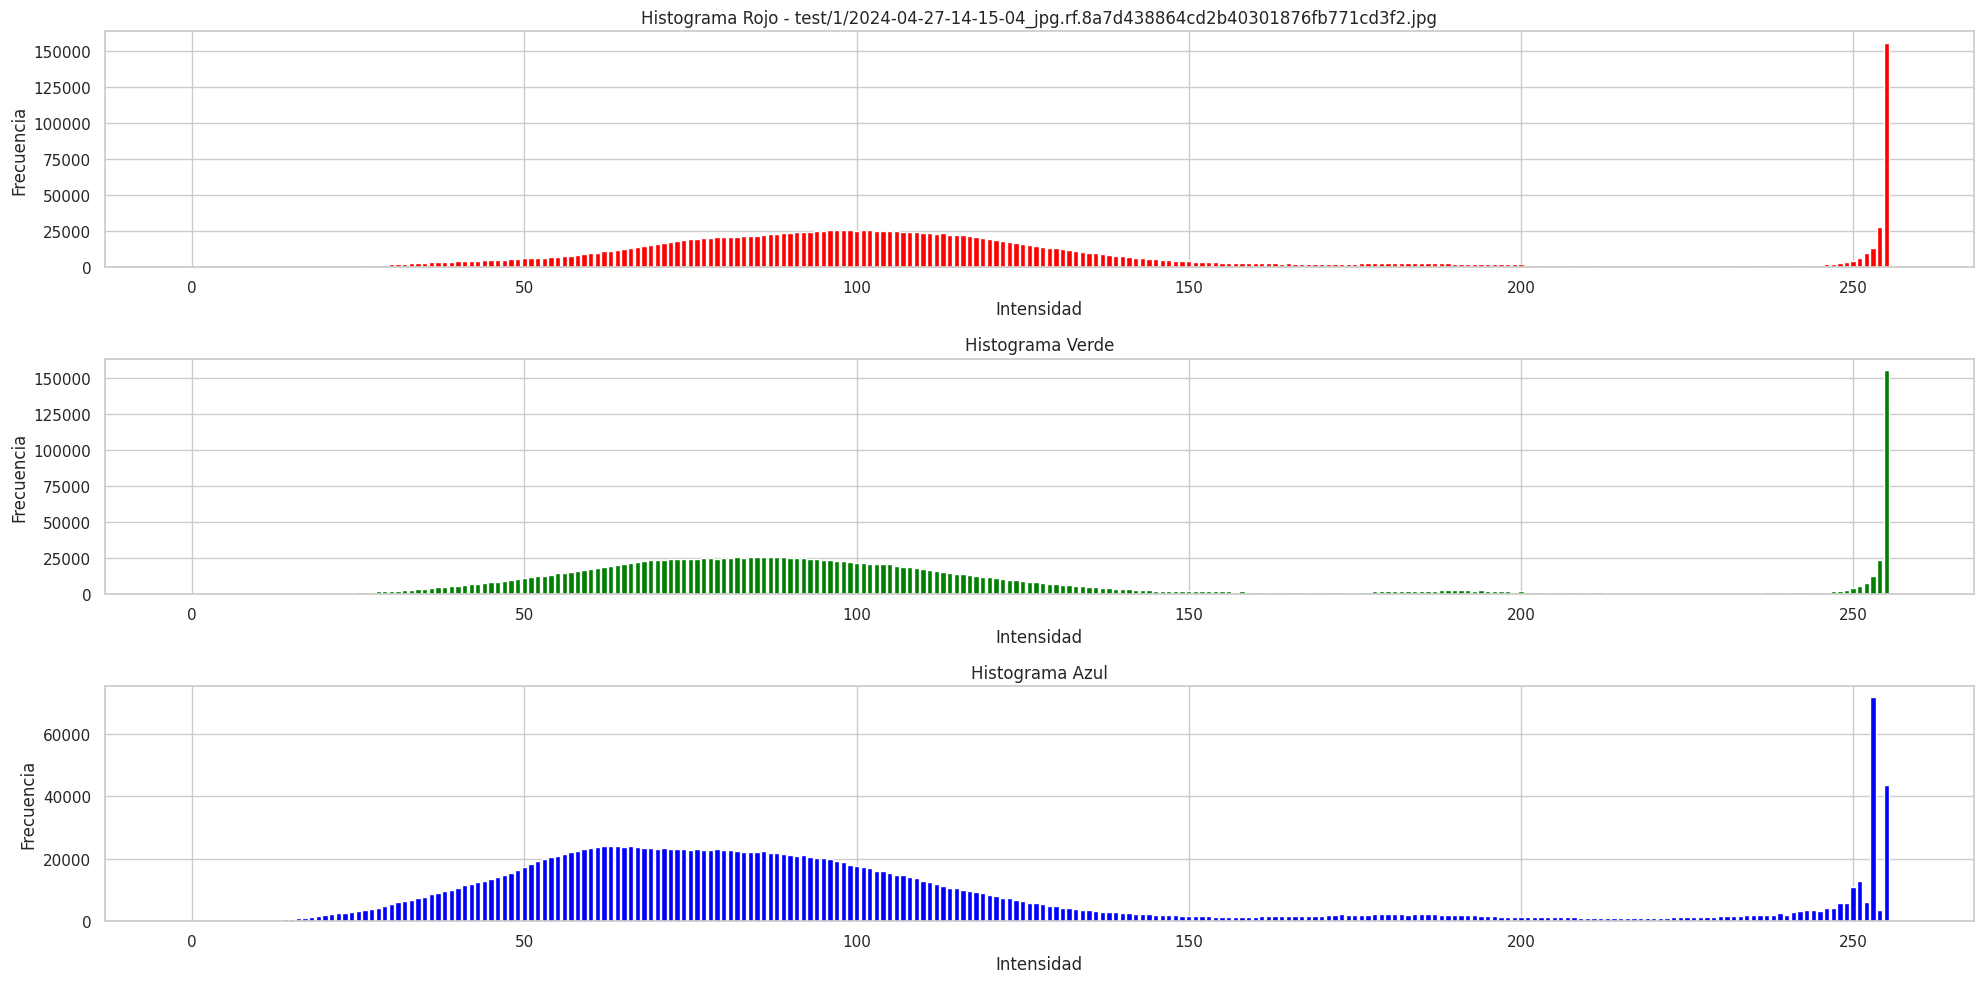

In [143]:
import random
import matplotlib.pyplot as plt

# Seleccionar una imagen al azar
random_index = random.randint(0, len(df)-1)
image_row = df.iloc[random_index]

# Extraer los histogramas
hist_red = image_row['Histogram_Red']
hist_green = image_row['Histogram_Green']
hist_blue = image_row['Histogram_Blue']

# Crear los histogramas
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)  # 3 filas, 1 columna, primer subplot
plt.bar(range(256), hist_red, color='red')
plt.title(f"Histograma Rojo - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 2)  # 3 filas, 1 columna, segundo subplot
plt.bar(range(256), hist_green, color='green')
plt.title("Histograma Verde")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.subplot(3, 1, 3)  # 3 filas, 1 columna, tercer subplot
plt.bar(range(256), hist_blue, color='blue')
plt.title("Histograma Azul")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Sobreponemos los 3 histogramas

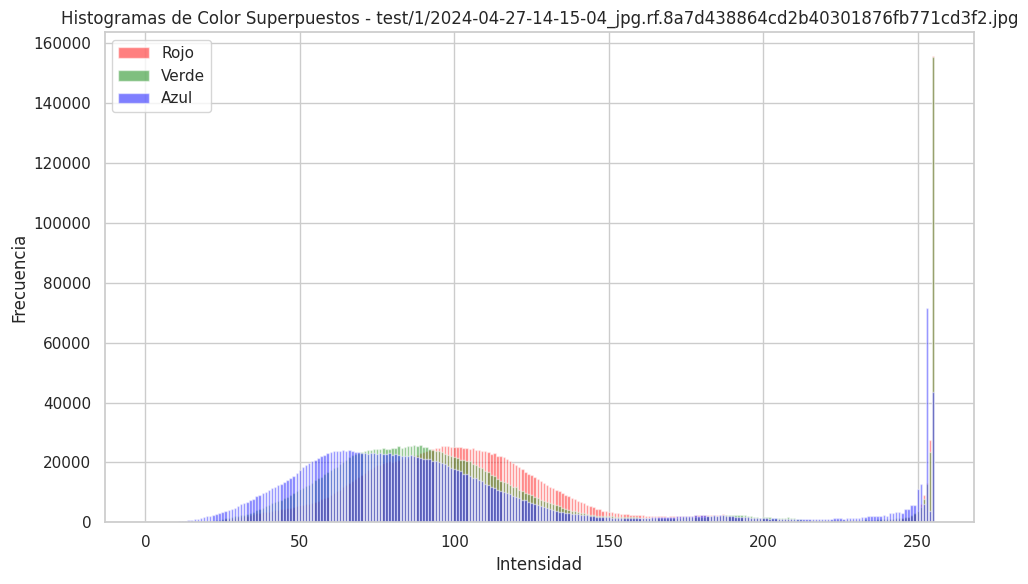

In [144]:
import matplotlib.pyplot as plt

# Crear una sola gráfica con los tres histogramas superpuestos
plt.figure(figsize=(10, 6))

plt.bar(range(256), hist_red, color='red', alpha=0.5, label='Rojo')
plt.bar(range(256), hist_green, color='green', alpha=0.5, label='Verde')
plt.bar(range(256), hist_blue, color='blue', alpha=0.5, label='Azul')

plt.title(f"Histogramas de Color Superpuestos - {image_row['Key']}")
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()


### Creamos el histograma promedio de todo el dataset 

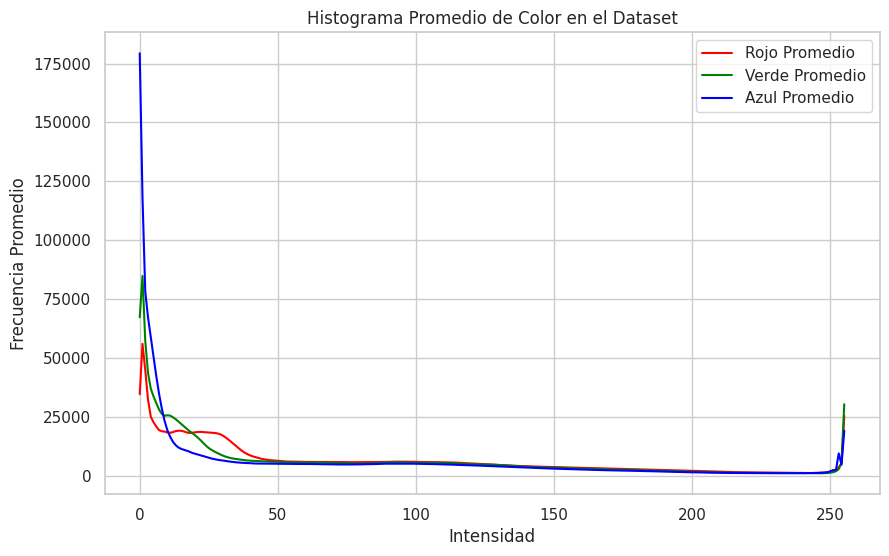

In [145]:
import numpy as np

# Inicializar arrays para acumular los histogramas
accum_hist_red = np.zeros(256)
accum_hist_green = np.zeros(256)
accum_hist_blue = np.zeros(256)

# Acumular los histogramas de todas las imágenes
for idx, row in df.iterrows():
    accum_hist_red += np.array(row['Histogram_Red'])
    accum_hist_green += np.array(row['Histogram_Green'])
    accum_hist_blue += np.array(row['Histogram_Blue'])

# Calcular los histogramas promedio
num_images = len(df)
avg_hist_red = accum_hist_red / num_images
avg_hist_green = accum_hist_green / num_images
avg_hist_blue = accum_hist_blue / num_images

# Graficar los histogramas promedio
plt.figure(figsize=(10, 6))
plt.plot(range(256), avg_hist_red, color='red', label='Rojo Promedio')
plt.plot(range(256), avg_hist_green, color='green', label='Verde Promedio')
plt.plot(range(256), avg_hist_blue, color='blue', label='Azul Promedio')
plt.title('Histograma Promedio de Color en el Dataset')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia Promedio')
plt.legend()
plt.show()


### Graficamos la luminosidad y el contraste de las imágenes en el dataset

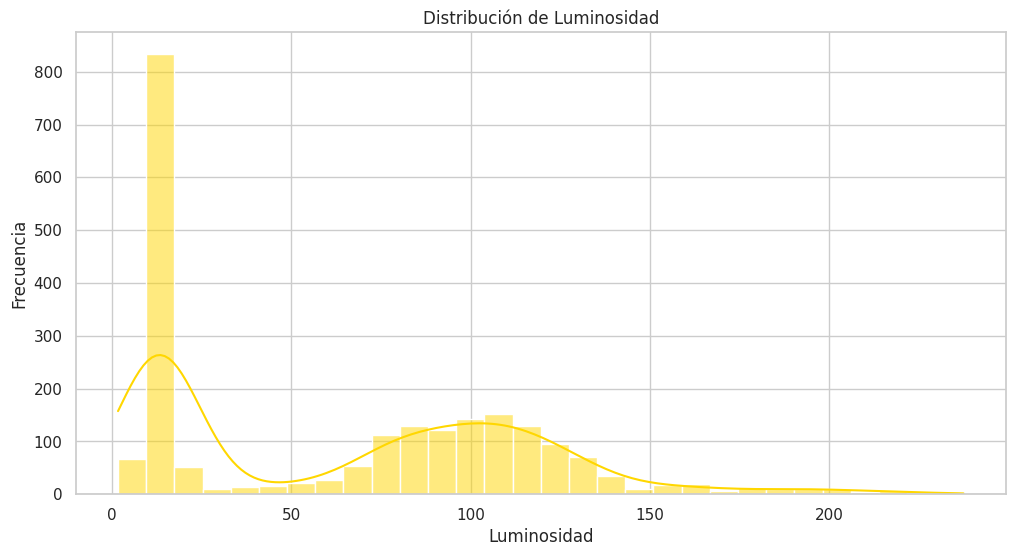

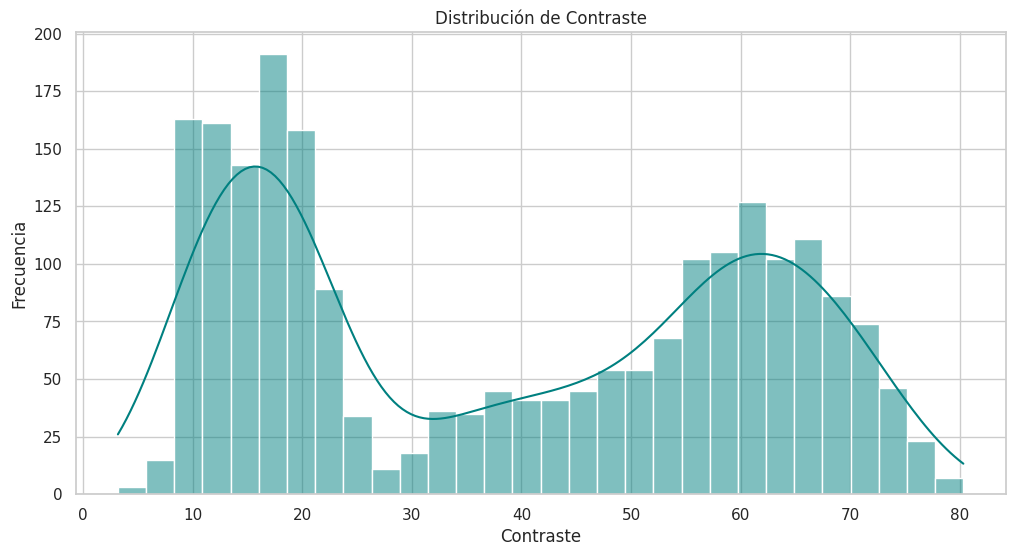

In [146]:
# Graficar la distribución de Luminosidad
plt.figure(figsize=(12, 6))
sns.histplot(df['Luminosity'], bins=30, kde=True, color='gold')
plt.title('Distribución de Luminosidad')
plt.xlabel('Luminosidad')
plt.ylabel('Frecuencia')
plt.show()

# Graficar la distribución de Contraste
plt.figure(figsize=(12, 6))
sns.histplot(df['Contrast'], bins=30, kde=True, color='teal')
plt.title('Distribución de Contraste')
plt.xlabel('Contraste')
plt.ylabel('Frecuencia')
plt.show()


### Vemos el promedio de luminosidad en el dataset

In [147]:
print(df['Luminosity'].describe())


count    2188.000000
mean       64.954606
std        51.597062
min         1.786648
25%        13.665167
50%        72.637358
75%       106.239983
max       237.350466
Name: Luminosity, dtype: float64


### Dividimos el dataset en baja media y alta

Ya no usamos cuantiles de luminosidad por la distribución de los datos

q1 = df['Luminosity'].quantile(0.25)

q3 = df['Luminosity'].quantile(0.75)

median_luminosity = df['Luminosity'].median()

print(f"Q1 (25%): {q1}")

print(f"Mediana (50%): {median_luminosity}")

print(f"Q3 (75%): {q3}")

### Filtramos las imágenes según la cateroría de luminosidad, q1, q2 y q3

In [155]:
# Definir los rangos de luminosidad
# luminosity_low_max = q1
# luminosity_average_min = q1
# luminosity_average_max = q3
# luminosity_high_min = q3
luminosity_low_max = 45
luminosity_average_min = 45
luminosity_average_max = 150
luminosity_high_min = 150

# Filtrar imágenes por categoría
low_luminosity_df = df[df['Luminosity'] <= luminosity_low_max]
average_luminosity_df = df[(df['Luminosity'] > luminosity_average_min) & (df['Luminosity'] <= luminosity_average_max)]
high_luminosity_df = df[df['Luminosity'] > luminosity_high_min]

# Verificar el número de imágenes en cada categoría
print(f"Número de imágenes con baja luminosidad: {len(low_luminosity_df)}")
print(f"Número de imágenes con luminosidad promedio: {len(average_luminosity_df)}")
print(f"Número de imágenes con alta luminosidad: {len(high_luminosity_df)}")


Número de imágenes con baja luminosidad: 979
Número de imágenes con luminosidad promedio: 1109
Número de imágenes con alta luminosidad: 100


### Función para descargar una imagen del s3 según la key

In [156]:
def download_image_from_s3(s3_client, bucket, key):
    try:
        response = s3_client.get_object(Bucket=bucket, Key=key)
        image_data = response['Body'].read()
        image = Image.open(BytesIO(image_data)).convert('RGB')  # Convertir a RGB si es necesario
        return image
    except Exception as e:
        print(f"Error al descargar o procesar la imagen {key}: {e}")
        return None


### Seleccionamos min y max en cada categoría

In [157]:
dark_low_idx = low_luminosity_df['Luminosity'].idxmin()
dark_high_idx = low_luminosity_df['Luminosity'].idxmax()

normal_low_idx = average_luminosity_df['Luminosity'].idxmin()
normal_high_idx = average_luminosity_df['Luminosity'].idxmax()

light_low_idx = high_luminosity_df['Luminosity'].idxmin()
light_high_idx = high_luminosity_df['Luminosity'].idxmax()


### Obtenemos la row completa

In [158]:
dark_low_row = low_luminosity_df.loc[dark_low_idx] if dark_low_idx is not None else None
dark_high_row = low_luminosity_df.loc[dark_high_idx] if dark_high_idx is not None else None

normal_low_row = average_luminosity_df.loc[normal_low_idx] if normal_low_idx is not None else None
normal_high_row = average_luminosity_df.loc[normal_high_idx] if normal_high_idx is not None else None

light_low_row = high_luminosity_df.loc[light_low_idx] if light_low_idx is not None else None
light_high_row = high_luminosity_df.loc[light_high_idx] if light_high_idx is not None else None


### Descargamos las 3 imágenes

In [159]:
# Inicializar el cliente de S3
s3 = boto3.client('s3')

# Descargar las imágenes
dark_low_image = download_image_from_s3(s3, BUCKET_NAME, dark_low_row['Key']) if dark_low_row is not None else None
dark_high_image = download_image_from_s3(s3, BUCKET_NAME, dark_high_row['Key']) if dark_high_row is not None else None

normal_low_image = download_image_from_s3(s3, BUCKET_NAME, normal_low_row['Key']) if normal_low_row is not None else None
normal_high_image = download_image_from_s3(s3, BUCKET_NAME, normal_high_row['Key']) if normal_high_row is not None else None

light_low_image = download_image_from_s3(s3, BUCKET_NAME, light_low_row['Key']) if light_low_row is not None else None
light_high_image = download_image_from_s3(s3, BUCKET_NAME, light_high_row['Key']) if light_high_row is not None else None

### Mostramos las 3 imágenes, una para cada nivel de luminosidad

In [160]:
normal_low_row

Key                test/4/2024-04-28-17-35-03_jpg.rf.f6a534dd370b...
Url                https://caetec-vacas.s3.amazonaws.com/test/4/2...
LastModified                               2024-10-14 18:23:57+00:00
Size                                                          197535
ETag                              "fa1c1ef658d5283434baefe29769da52"
StorageClass                                                STANDARD
Width                                                         1920.0
Height                                                        1080.0
Luminosity                                                 45.186983
Contrast                                                   41.811504
Histogram_Red      [415, 2377, 17906, 13442, 10939, 10803, 10964,...
Histogram_Green    [571, 3240, 21404, 16341, 21664, 25034, 30868,...
Histogram_Blue     [276573, 137360, 123234, 100229, 86241, 72160,...
Name: 1503, dtype: object

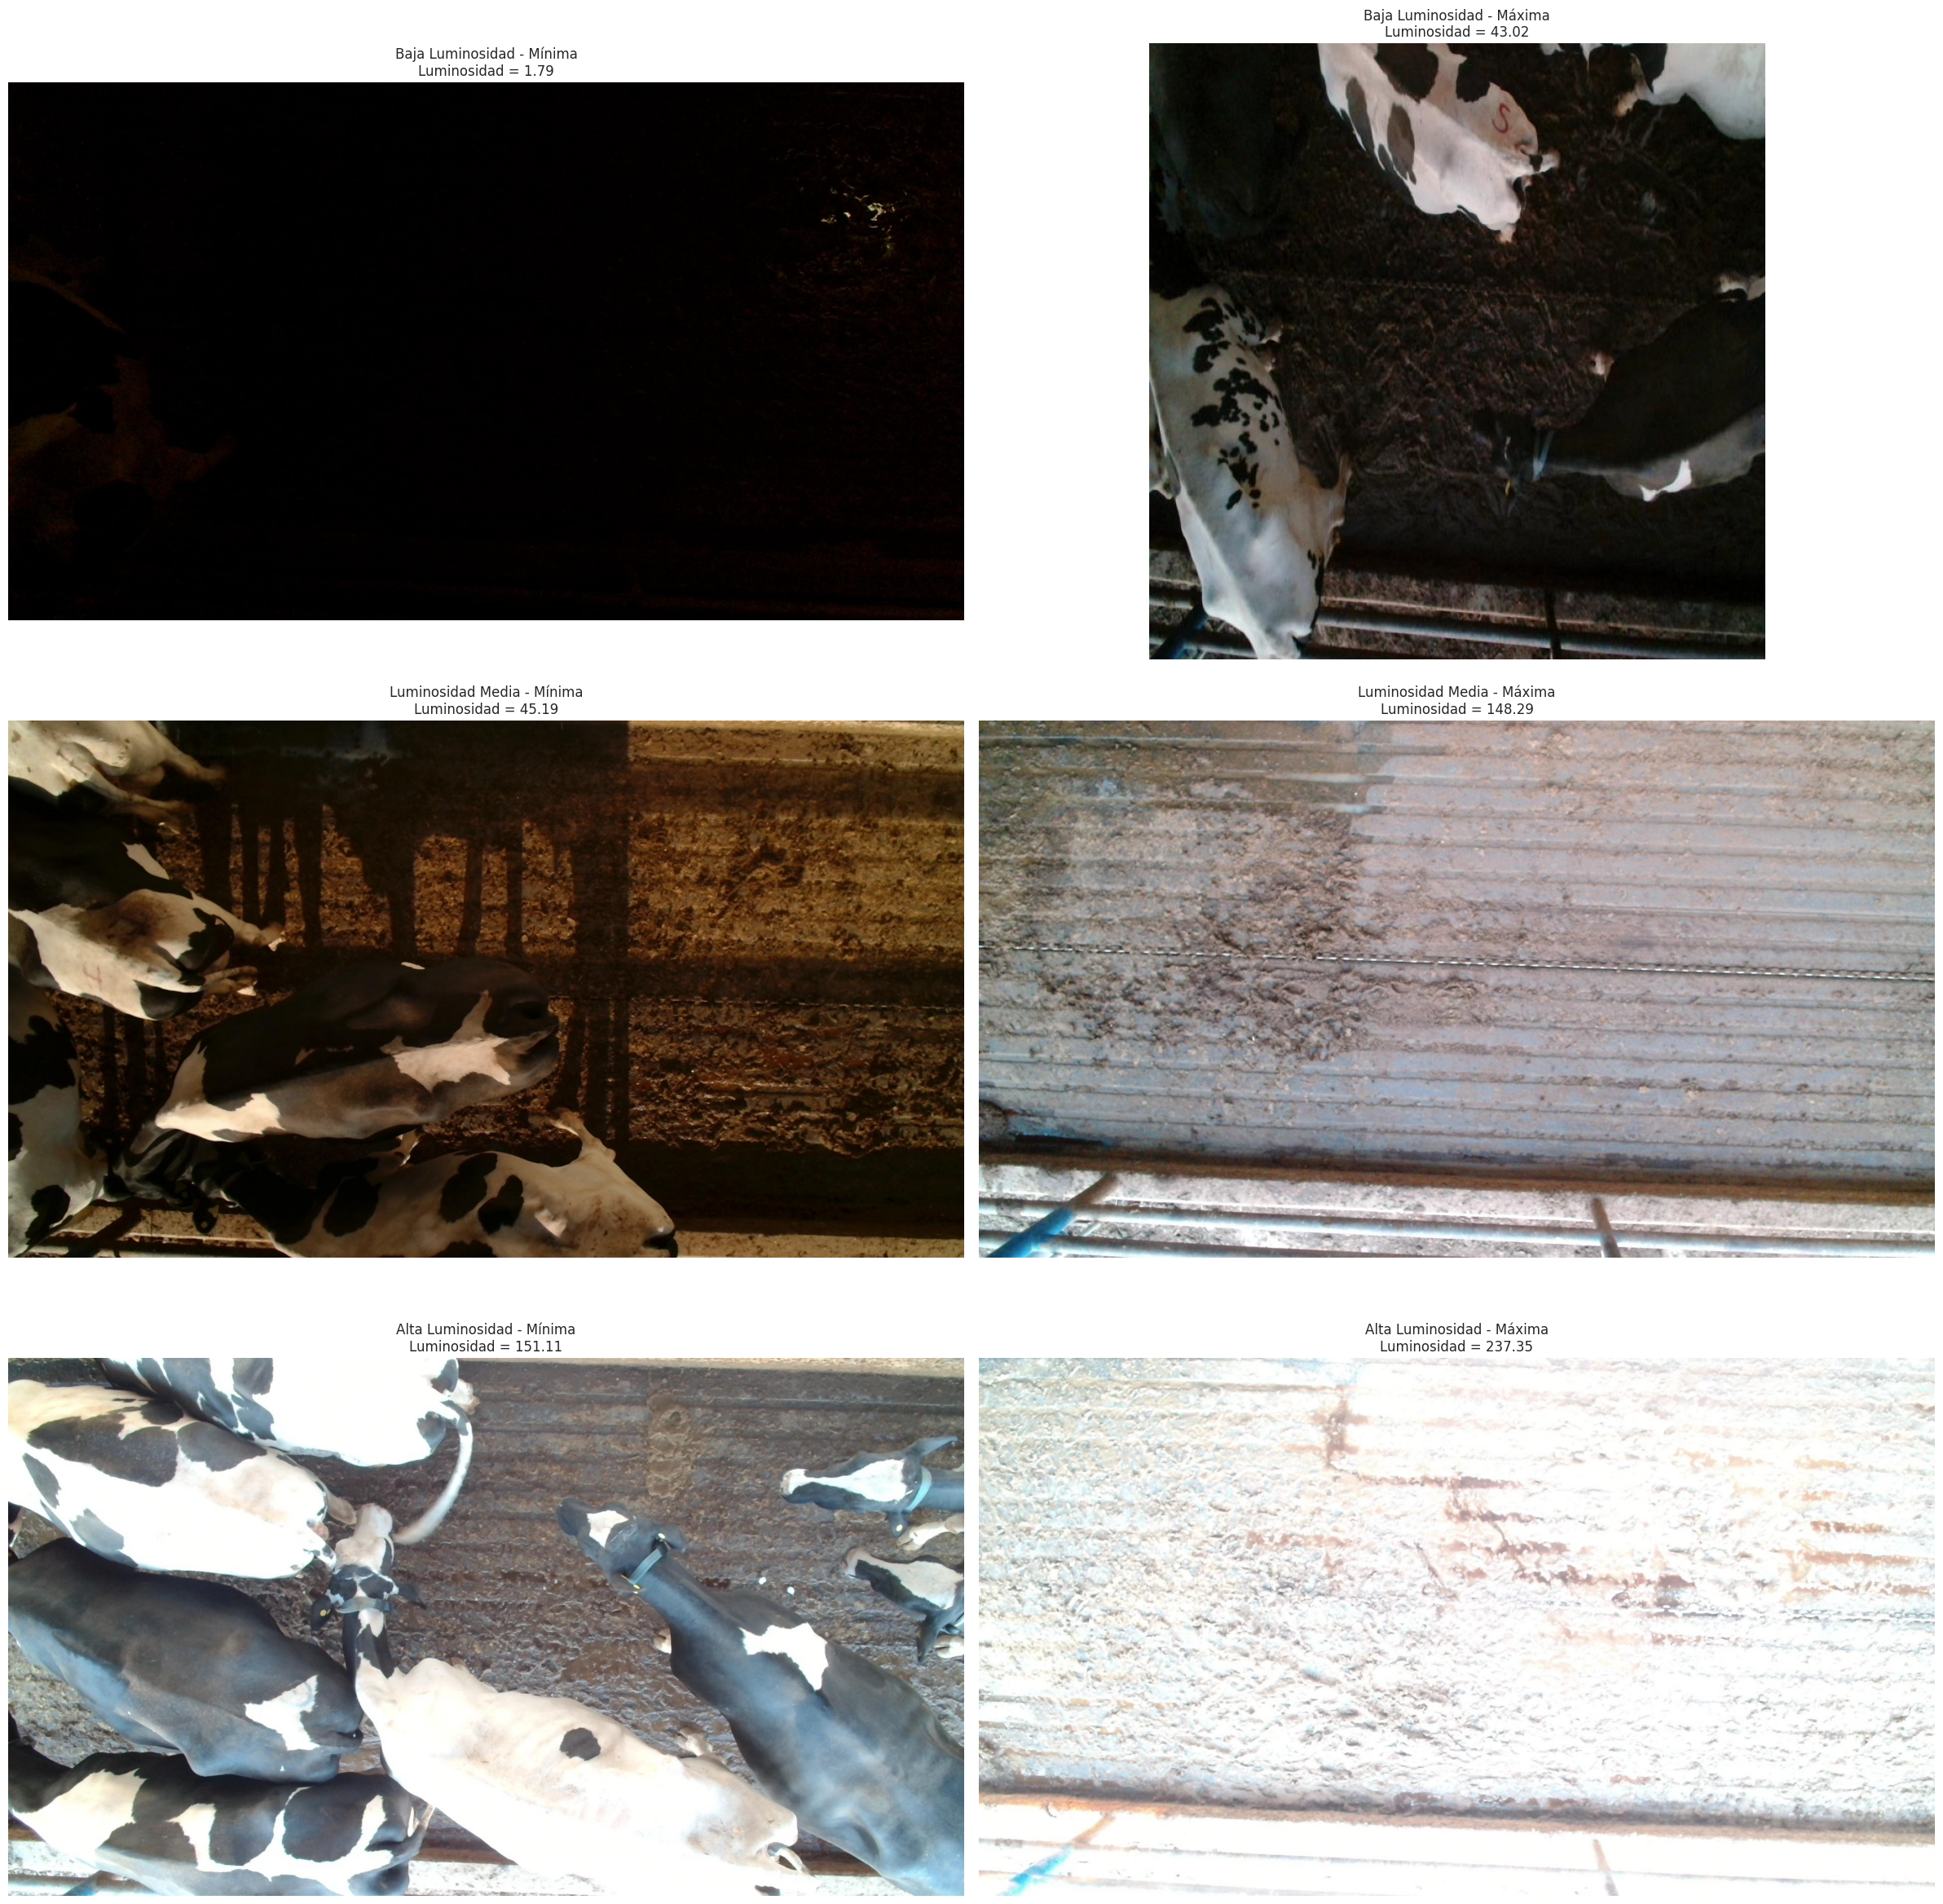

In [162]:
# Crear una figura con 3 filas y 3 columnas de subplots
fig, axes = plt.subplots(3, 2, figsize=(24, 24))

# Definir las imágenes y sus títulos
# images = [
#     (dark_low_image, f'Baja Luminosidad - Mínima\nLuminosidad = {dark_low_row["Luminosity"]:.2f}' if dark_low_row else 'Baja Luminosidad - Mínima\nNo hay imagen'),
#     (dark_high_image, f'Baja Luminosidad - Máxima\nLuminosidad = {dark_high_row["Luminosity"]:.2f}' if dark_high_row else 'Baja Luminosidad - Máxima\nNo hay imagen'),

#     (normal_low_image, f'Luminosidad Media - Mínima\nLuminosidad = {normal_low_row["Luminosity"]:.2f}' if normal_low_row else 'Luminosidad Media - Mínima\nNo hay imagen'),
#     (normal_high_image, f'Luminosidad Media - Máxima\nLuminosidad = {normal_high_row["Luminosity"]:.2f}' if normal_high_row else 'Luminosidad Media - Máxima\nNo hay imagen'),

#     (light_low_image, f'Alta Luminosidad - Mínima\nLuminosidad = {light_low_row["Luminosity"]:.2f}' if light_low_row else 'Alta Luminosidad - Mínima\nNo hay imagen'),
#     (light_high_image, f'Alta Luminosidad - Máxima\nLuminosidad = {light_high_row["Luminosity"]:.2f}' if light_high_row else 'Alta Luminosidad - Máxima\nNo hay imagen')
# ]

# Definir las imágenes y sus títulos
images = [
    (dark_low_image, f'Baja Luminosidad - Mínima\nLuminosidad = {dark_low_row["Luminosity"]:.2f}'),
    (dark_high_image, f'Baja Luminosidad - Máxima\nLuminosidad = {dark_high_row["Luminosity"]:.2f}'),

    (normal_low_image, f'Luminosidad Media - Mínima\nLuminosidad = {normal_low_row["Luminosity"]:.2f}'),
    (normal_high_image, f'Luminosidad Media - Máxima\nLuminosidad = {normal_high_row["Luminosity"]:.2f}'),

    (light_low_image, f'Alta Luminosidad - Mínima\nLuminosidad = {light_low_row["Luminosity"]:.2f}'),
    (light_high_image, f'Alta Luminosidad - Máxima\nLuminosidad = {light_high_row["Luminosity"]:.2f}')
]

# Iterar sobre los subplots y asignar imágenes
for ax, (img, title) in zip(axes.flatten(), images):
    if img:
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
    else:
        ax.text(0.5, 0.5, 'No hay imagen', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig('cows_luminosity.png')
plt.show()
